<a href="https://colab.research.google.com/github/Edrasen/Advanced_Neuronal_Networks/blob/main/Shape_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importamos las librerias a utilizar

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image,ImageOps
import os
import math
import json
from io import StringIO
import skimage as ski
from skimage import data, io, filters, feature, segmentation, morphology, color
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.feature import corner_harris, corner_subpix, corner_peaks

# Procesamiento de la imagen

Primero haremos el clone del reposositorio del cual tomaremos las imagenes necesarias.

In [40]:
!git clone https://github.com/Edrasen/Advanced_Neuronal_Networks.git
#git pull

Cloning into 'Advanced_Neuronal_Networks'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 83 (delta 43), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (83/83), done.


In [41]:
%cd Advanced_Neuronal_Networks/
!pwd

/content/Advanced_Neuronal_Networks/Advanced_Neuronal_Networks
/content/Advanced_Neuronal_Networks/Advanced_Neuronal_Networks


In [42]:
figuras = os.path.join("figuras.jpg")
foto = os.path.join("foto.jpg")

In [43]:
fig = Image.open(figuras).convert('L')  #Abrimos la imagen
fot = Image.open(foto).convert('L')

In [44]:
m_figu = np.array(fig)  #creamos la matriz de la imagen
m_foto = np.array(fot)

In [45]:
print(m_figu.shape)
print(m_foto.shape)

(720, 960)
(244, 322)


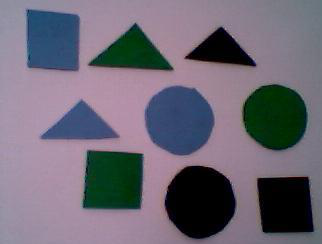

In [46]:
my_foto = Image.open(foto)
my_foto

Aplicamos un análisis con los momentos de Hu


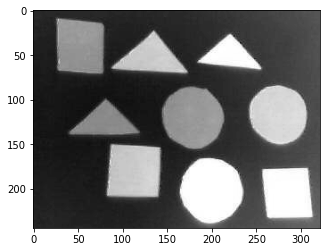

In [47]:
#invertimos la imagen
nfoto = ski.util.invert(m_foto)
plt.imshow(nfoto, cmap='gray')

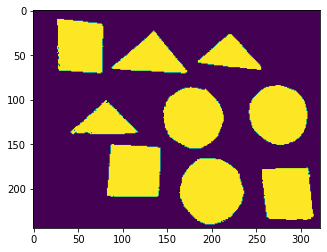

In [48]:
#aplicando el umbral al la imagen de prueba
thresh = filters.threshold_otsu(nfoto)
umbral_foto = morphology.opening(nfoto > thresh, morphology.square(1))
plt.imshow(umbral_foto)

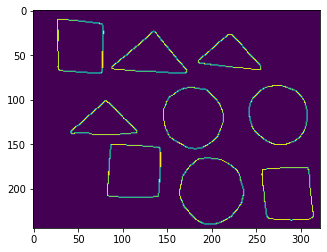

In [49]:
img_edges = ski.feature.canny(umbral_foto)
plt.imshow(img_edges)

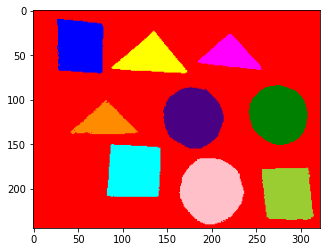

In [50]:
#etiquetar regiones 
label_image=ski.measure.label(umbral_foto)
plt.imshow(ski.color.label2rgb(label_image))

In [51]:
regions = ski.measure.regionprops(label_image)
for prop in regions[0]:
  print(prop)

area
bbox
bbox_area
centroid
convex_area
convex_image
coords
eccentricity
equivalent_diameter
euler_number
extent
filled_area
filled_image
image
inertia_tensor
inertia_tensor_eigvals
label
local_centroid
major_axis_length
minor_axis_length
moments
moments_central
moments_hu
moments_normalized
orientation
perimeter
slice
solidity


In [52]:
coordinates = []
for region in regions:
  coordinates.append(region['bbox'])

print(coordinates)

[(10, 27, 71, 79), (23, 88, 71, 173), (27, 185, 67, 256), (84, 242, 151, 308), (86, 146, 155, 214), (101, 42, 139, 118), (150, 83, 209, 143), (166, 164, 240, 237), (176, 257, 235, 315)]


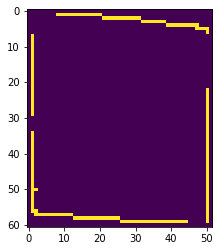

In [53]:
#plt.imshow(regions[0]['filled_image'])
test = ski.feature.canny(regions[0]['filled_image'])
plt.imshow(test)

# Preparando los datos

In [54]:
def get_hu_moment(img):
  nimg = ski.util.invert(img)
  timg = filters.threshold_otsu(nimg)
  uimg = morphology.opening(nimg > timg, morphology.square(1))
  label_img = ski.measure.label(uimg)
  regions = ski.measure.regionprops(label_img)
  momento = regions[0].moments_hu
  return momento

In [55]:
def Lector_forma_training(Train_dir, jsonfile):
  Train_data = []
  Tags = []
  with open(jsonfile) as data_file:
    etiquetas = json.load(data_file)
  for img in os.listdir(Train_dir):
    try:
      #print(img)
      imgtag = etiquetas[img]
      Tags.append(imgtag)
    except:
      print("Tag error: " + img)
    try:
      imgpath = os.path.join(Train_dir, img)
      img = Image.open(imgpath).convert('L')
      Train_data.append(get_hu_moment(np.array(img)))
    except:
      print("File error: "+ img)
  
  return np.array(Train_data), Tags

In [56]:
def Lector_forma_testing(jsonfile):
    Train_data=[] #Arreglo de datos
    Tags=[] #Arreglo de etiquetas

    with open(jsonfile) as data_file: #Abrir el archivo Jason  
         etiquetas = json.load(data_file) #Guardar la lista del archivo jason en un arreglo
    #Tomamos cada bbox y momento de hu de cada objeto
    for region in regions:
        try:
            imgtag=etiquetas[format(region.bbox)]
            Tags.append(imgtag)
        except:
            print("Tag error: "+format(region.bbox)) 
        try:
            Train_data.append(region.moments_hu)
        except:
            print("Tag error: "+format(region.bbox))
    return np.array(Train_data),Tags 

In [57]:
X_train, y_train = Lector_forma_training("Forma/Train", "Train_forma.json")

In [58]:
X_train

array([[ 2.03237556e-01,  4.35103112e-03,  4.84017506e-03,
         1.48895497e-04,  1.21646059e-07,  9.07956008e-06,
        -3.43456488e-08],
       [ 1.59363835e-01,  4.70728980e-05,  1.47853221e-06,
         8.70578230e-10, -1.44294030e-17, -3.05572000e-12,
        -2.77011337e-17],
       [ 2.59643304e-01,  3.10260121e-02,  6.15394146e-03,
         4.00297470e-04, -6.01233970e-07, -6.82681946e-05,
         1.82343948e-07],
       [ 2.35369349e-01,  1.86665344e-02,  5.78022420e-03,
         4.90077394e-04,  4.14072037e-07,  1.59895609e-05,
         7.13375236e-07],
       [ 2.41138330e-01,  2.15353724e-02,  5.72361653e-03,
         3.07096041e-04, -3.93041894e-07, -4.37410968e-05,
        -1.06222411e-07],
       [ 1.59896185e-01,  2.18448482e-04,  5.22116463e-07,
         1.51814327e-09,  2.11448854e-17,  8.89233285e-12,
        -3.71450600e-17],
       [ 1.66777394e-01,  1.72702387e-05,  1.54605557e-06,
         1.71553071e-07, -1.35138112e-14,  4.70336503e-10,
        -8.7311132

In [59]:
X_test, y_test = Lector_forma_testing("Test_forma.json")

In [60]:
X_test

array([[ 1.68622069e-01,  6.28504304e-04,  8.43750471e-06,
         2.64043191e-07,  2.14744489e-13, -7.96786159e-11,
        -3.30467761e-13],
       [ 2.19693668e-01,  1.12609527e-02,  5.33069618e-03,
         2.00354324e-04, -1.60700445e-07, -1.78749246e-05,
        -1.30567966e-07],
       [ 2.20480103e-01,  1.29730008e-02,  4.78587936e-03,
         2.22880939e-04, -1.23206425e-07, -1.67714297e-05,
         1.94444192e-07],
       [ 1.59546922e-01,  8.93004395e-05,  6.25132758e-06,
         4.36458653e-09, -4.02693325e-16, -2.54298778e-11,
         5.97993782e-16],
       [ 1.59448424e-01,  4.65015941e-05,  1.72165424e-06,
         1.32864007e-09, -5.51420644e-17, -8.78036091e-12,
         3.15811359e-17],
       [ 2.22406944e-01,  1.38124378e-02,  4.71036203e-03,
         2.16963520e-04, -1.15333671e-07, -1.78579647e-05,
        -1.86563200e-07],
       [ 1.66265353e-01,  2.21463042e-05,  1.21591723e-05,
         2.75946081e-07,  1.51513091e-13,  1.07249173e-09,
         4.8221927

# Ajustar parámetros del modelo

In [61]:
clfshape = MLPClassifier(solver='lbfgs', alpha=1e-4,
                  hidden_layer_sizes=(10, 3), random_state=1)

# Ajuste del modelo

In [62]:
clfshape.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 3), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [63]:
pred = clfshape.predict(X_test)

# Evaluar el modelo

In [64]:
def ClassDetector(onehot):
  output=[]
  for case in onehot:
    output.append(np.argmax(case))
  return output

In [65]:
predclass = ClassDetector(pred)
yclass = ClassDetector(y_test)
print(yclass)

[2, 0, 0, 1, 1, 0, 2, 1, 2]


In [66]:
print(accuracy_score(predclass,yclass))

1.0


In [67]:
print(confusion_matrix(predclass,yclass))

[[3 0 0]
 [0 3 0]
 [0 0 3]]
